In [1]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
source='data/source/'
tic=time.time()

def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   
def get_ts(x):
    chrom=x['ch']
    com=set(range(x['b'],x['e'])).intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp['chrom']==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)
def f(x):
    return int(x.name.split('_')[1])-1 in hzg[x.name.split('_')[0]]

In [25]:
ind=pd.read_table('data/meth/h/Mouse_ESC.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [26]:
    c={};cg={}
    s='h'
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

39073,

In [27]:
h=c['h']
bw=source+'GSM2472741_E14_Ezh2_Rep1.bw'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [28]:
ez14_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE94nnn/GSE94300/suppl/GSE94300_E14Ezh2_MAnorm_unbiased.bed.gz' #
ez14=[]
ez=pd.read_table(ez14_,header=None)
ez.columns=['chrom', 'chromStart', 'chromEnd']
print(ez.shape)
for ch in range(1,20):
    ezc=ez[ez['chrom']=='chr'+str(ch)]
    print(len(ezc),end=',')
    ezc.loc[:,'r']=ezc.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ezc=ezc['r'].tolist()
    ezc=set([item for sublist in ezc for item in sublist])   
    print(len(ezc),end='-')
    for b in ezc:
        ez14.append(['chr'+str(ch),b])
ez14=pd.DataFrame(ez14) 
ez14['ezh']=True
ez14.index=ez14[0].str[3:5]+'_'+ez14[1].astype(str)

(7213, 3)
462,526102-687,899107-337,395428-455,508115-474,596826-400,520490-438,488638-400,473660-374,426816-293,335768-536,651924-332,389072-351,426337-286,369904-320,377446-155,193966-266,307134-252,284005-227,286329-

In [29]:
ezg=ez14.groupby(0)[1].apply(list)
ezg=ezg.apply(lambda x:set(x))

In [30]:
h['ezl']=h.apply(lambda x:len(x['r'].intersection(ezg[x['ch']])),axis=1)

In [31]:
hz=h.sort_values('ezl',ascending=False).head(100)
print(len(hz))

100


In [32]:
hzg=hz.groupby('ch')['r'].apply(list)
hzg=hzg.apply(lambda x:set.union(*x)) 
hzs=[]
for i,r in hz.iterrows():
    for rr in r['r']:
        hzs.append((r['ch'],rr+1))
hzs=pd.DataFrame(hzs)     
hzs.index=hzs[0].str[3:5]+'_'+(hzs[1]-1).astype(str)
len(hzs)

38088

In [33]:
h.to_csv('data/h.csv')

In [ ]:
#h=pd.read_csv('data/h.csv',engine='c',index_col=0)

In [35]:
hg=h.groupby('ch')['r'].apply(list)
hg=hg.apply(lambda x:set.union(*x))

In [36]:
#hg.to_csv('data/hg.csv')

In [20]:
#hg=pd.read_csv('data/hg.csv',index_col=0,engine='c').squeeze()

In [ ]:
fs=['SRR44738'+str(i) for i in range(55,71)]
for sn in fs:
    path='data/meth/l/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

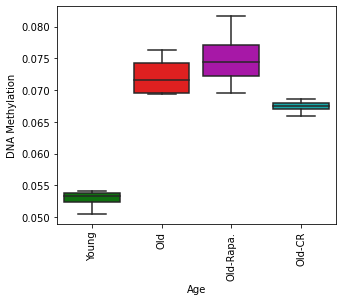

In [11]:
p=pd.DataFrame(hz[fs].mean())
p['Age']=4*['Young']+4*['Old']+4*['Old-Rapa.']+4*['Old-CR']
#p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(5,4))
ax=sns.boxplot(data=p,x='Age',y=0,palette=['g','r','m','c'])
ax.set( ylabel='DNA Methylation')
ax.tick_params(axis='x', rotation=90)

In [6]:
df=pd.read_csv('../../aging/mice/data/blood.csv',engine='c',index_col=0)
len(df)

1940728

In [ ]:
df.index='chr'+df.index
dfhz=df[df.apply(lambda x:f(x),axis=1)]
dfhz.columns=dfhz.columns.astype(int)
len(dfhz)

In [175]:
age=pd.read_csv('../../aging/mice/data/blood_age.csv',index_col=0)
len(age)

195

In [176]:
age=age.merge(dfhz.mean().rename('m'),left_index=True,right_index=True)

In [177]:
age.columns=['Diet','age','Avergae DNAm']
age.head(1)

,Diet,age,Avergae DNAm
2132712,diet: standard,0.67,4.777591


In [181]:
age['Age (month)']=pd.cut(age.age,[0,12,24,36])

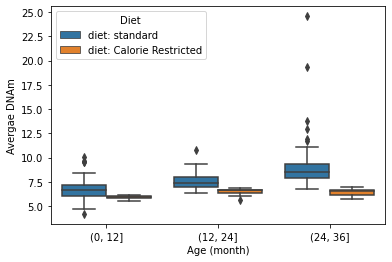

In [182]:
ax=sns.boxplot(data=age,x='Age (month)',y='Avergae DNAm',hue='Diet')

In [2]:
rrbs='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE120nnn/GSE120137/matrix/GSE120137-GPL21103_series_matrix.txt.gz'
age=pd.read_table(rrbs,skiprows=31).T
age=age.drop('!Sample_title')
age['age']=age[10].str[5:].str[:-2].astype(float)
age['id']=age.index.str[-3:]

In [3]:
ps={}

In [4]:
fs=glob.glob('data/meth/GSE120137/b/*.txt')
fs.sort()
len(fs)

72

In [ ]:
n=7
dfs=[]
for sn in fs:
    name=sn.split('SH')[1][:3]
    print(name,end=',')
    df=pd.read_table(sn,engine='c',sep=' ',header=None,nrows=10**n)
    df=df[df[0].isin(hg.index)]
    df['hmr']=df.apply(lambda x:x[2]-1 in hg[x[0]],axis=1)
    df=df[df['hmr']][[0,2,5]]
    df.index=df[0].str[3:5]+'_'+(df[2]-1).astype(str)
    #h[name]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    dfs.append(df[5].rename(name))

001,005,006,007,008,009,010,011,012,013,014,015,016,017,018,019,020,030,033,034,035,

In [ ]:
for df in dfs:
    print (df.name,end=',')
    df.to_csv('data/meth/GSE120137/n/csv/'+df.name+'.csv')

In [544]:
for c in ['m','a','k','l','u','b']:
    fs=glob.glob('data/meth/GSE120137/'+c+'/csv/*.csv')
    dfs=[]
    for f in fs:
        print ('',end=',')
        df=pd.read_csv(f,index_col=0)
        df=df[df.index.isin(hzs.index)]
        dfs.append(df)
    df=dfs[0].merge(dfs[1],left_index=True,right_index=True,how='outer')
    for i in range(2,len(dfs)):
        print(i,end=',')
        df=df.merge(dfs[i],left_index=True,right_index=True,how='outer')
    df.shape
    p=df.mean()
    p=p.rename('DNAm')
    ps['u']=age[['id','age']].drop_duplicates().merge(p,left_on='id',right_index=True)    

(24716, 57)

In [547]:
ps['m']['tissue']='Muscle'
ps['a']['tissue']='Adipose'
ps['k']['tissue']='Kidney'
ps['l']['tissue']='Liver'
ps['u']['tissue']='Lung'
ps['b']['tissue']='Blood'

<AxesSubplot:xlabel='tissue', ylabel='DNAm'>

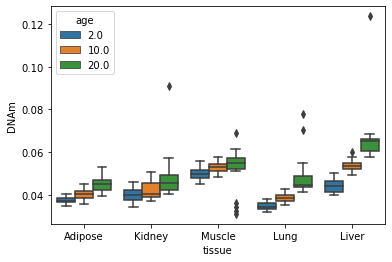

In [549]:
sns.boxplot(data=pd.concat(ps),x='tissue',y='DNAm',hue='age'
            ,order=['Adipose','Kidney','Muscle','Lung','Liver','Blood'])